This example uses the carvana dataset. Images and masks are resized to 3x64x64.

In [1]:
import os
import pickle
import sys
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # progress bar

sys.path.append('../../src')

## some parameters

In [2]:
batch_size = 32
learning_rate = 1e-3
epochs = 20

## only use dataset and dataloader from pytorch

In [3]:
from albumentations import Compose, Rotate, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url, extract_archive, check_integrity

## create dataset

In [4]:
class CarvanaDataset(Dataset):
    def __init__(self, root, train=True, transform=None):

        fn = 'train64' if train else 'test64'
        with open(f'{root}/{fn}', 'rb') as f:
            data = pickle.load(f)
        self.images = (data['images'] / 255).astype(np.float32)
        self.masks = data['masks'].astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index].reshape(64, 64, 3)
        mask = self.masks[index].reshape(64, 64)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"][None, ...]
        return image, mask

In [5]:
transform_augmented = Compose([
    Rotate(limit=35, p=1.0),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.1),
    ToTensorV2()])

transform = Compose([
    ToTensorV2()])

valset, trainset = random_split(CarvanaDataset('./dataset', train=True, transform=transform_augmented), [646, 3658])
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = CarvanaDataset('./dataset', train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True) # shuffle to show different types of cars

print('size of train set', len(trainset))
print('size of validation set', len(valset))
print('size of test set', len(testset))

size of train set 3658
size of validation set 646
size of test set 784


## the rest is done in pytortto
tensors loaded using `pytorch` will be converted to `tortto` tensors.

In [6]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

## define the model: U-Net

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super(UNet, self).__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        for f in features:
            self.down.append(DoubleConv(in_channels, f))
            in_channels = f
        self.bottle_neck = DoubleConv(f, 2 * f)
        for f in reversed(features):
            self.up.append(nn.ConvTranspose2d(2 * f, f, kernel_size=2, stride=2))
            self.up.append(DoubleConv(2 * f, f))
        self.out = nn.Conv2d(f, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for m in self.down:
            x = m(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottle_neck(x)
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.up), 2):
            skip_connection = skip_connections[i // 2]
            x = self.up[i](x, output_size=skip_connection.shape[-2:])  # upsample
            x = tt.cat([skip_connections[i // 2], x], dim=1)  # cat
            x = self.up[i + 1](x)  # double conv
        x = self.out(x)
        return x

In [8]:
net = UNet(in_channels=3, out_channels=1, features=[32,64,128,256]).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## define functions for training and validation

In [9]:
def calculate_loss(batch):
    inputs, labels = batch
    
    # convert pytorch tensor to tortto tensor
    inpt = tt.tensor(inputs.numpy()).cuda()
    lab = tt.tensor(labels.numpy()).cuda()
    
    # forward
    outputs = net(inpt)
    loss = criterion(outputs, lab)

    return loss
    
    
def train():
    # train
    net.train()
    loop = tqdm(train_loader)
    train_loss = 0
    for i, batch in enumerate(loop):

        # zero the parameter gradients
        optimizer.zero_grad()

        loss = calculate_loss(batch)
        
        # accumulate loss
        train_loss += loss.item()

        # backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

    # keep track of train loss and train error
    loss_history['train'].append(train_loss / (i + 1))
    

@tt.no_grad()
def val_test(dataloader):
    net.eval()
    total_loss = 0
    loop = tqdm(dataloader)
    for i, batch in enumerate(loop):
        
        # cal loss
        loss = calculate_loss(batch)
        
        # accumulate val loss
        total_loss += loss.item()
    
    avg_loss = total_loss / (i + 1)
    return avg_loss

    
def save():
    global lowest_loss
    # save checkpoint
    if epoch > 10 and loss_history['val'][-1] < lowest_loss:
        checkpoint = {
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            }
        tt.save(checkpoint, f'models/checkpoint_{str(epoch).zfill(3)}.npy')
        lowest_loss = loss_history['val'][-1]
    
    # save loss history and log
    tt.save(loss_history, 'logs/loss_history.npy')
    with open('logs/log.txt','a') as f:
        f.write('epoch{} finished at {}. val_loss: {:.4f}\n'.
                format(str(epoch).zfill(3), 
                       datetime.now().strftime("%m/%d/%Y, %H:%M:%S"), 
                       loss_history['val'][-1]))

## train the network

In [10]:
loss_history = {'train': [], 'val': []}

lowest_loss = 100

for epoch in range(epochs):

    # train
    train()
    
    # validation
    val_loss = val_test(val_loader)
    loss_history['val'].append(val_loss)
    print(' - val_loss: {:.4f}\n'.format(loss_history['val'][-1]))

    # save
    save()

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.16it/s]


 - val_loss: 0.1274



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.24it/s]


 - val_loss: 0.0682



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 29.90it/s]


 - val_loss: 0.0505



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.77it/s]


 - val_loss: 0.0427



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 29.96it/s]


 - val_loss: 0.0591



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.97it/s]


 - val_loss: 0.0404



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 29.55it/s]


 - val_loss: 0.0374



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.87it/s]


 - val_loss: 0.0413



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 31.04it/s]


 - val_loss: 0.0320



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 31.13it/s]


 - val_loss: 0.0327



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 29.58it/s]


 - val_loss: 0.0320



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.53it/s]


 - val_loss: 0.0297



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.79it/s]


 - val_loss: 0.0313



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.44it/s]


 - val_loss: 0.0294



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 28.69it/s]


 - val_loss: 0.0298



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 31.06it/s]


 - val_loss: 0.0278



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.87it/s]


 - val_loss: 0.0375



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 31.03it/s]


 - val_loss: 0.0270



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.84it/s]


 - val_loss: 0.0271



100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 30.52it/s]


 - val_loss: 0.0264



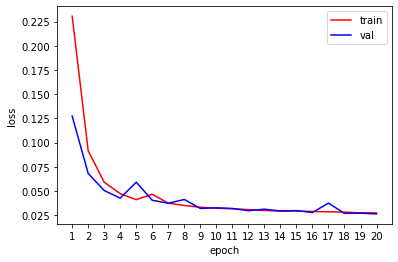

In [11]:
loss_history = tt.load('logs/loss_history.npy')
plt.plot(loss_history['train'], 'r', label='train')
plt.plot(loss_history['val'], 'b', label='val')
plt.xticks(ticks=range(len(loss_history['train'])), labels=range(1, 1 + len(loss_history['train'])))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## evaluation on test set

load the checkpoint with the lowest loss

In [12]:
# load checkpoint
checkpoint = tt.load('models/checkpoint_019.npy')
net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [13]:
test_loss = val_test(test_loader)
print(f'Test loss: {test_loss:.4f}')

100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 33.02it/s]

Test loss: 0.0231


## some examples

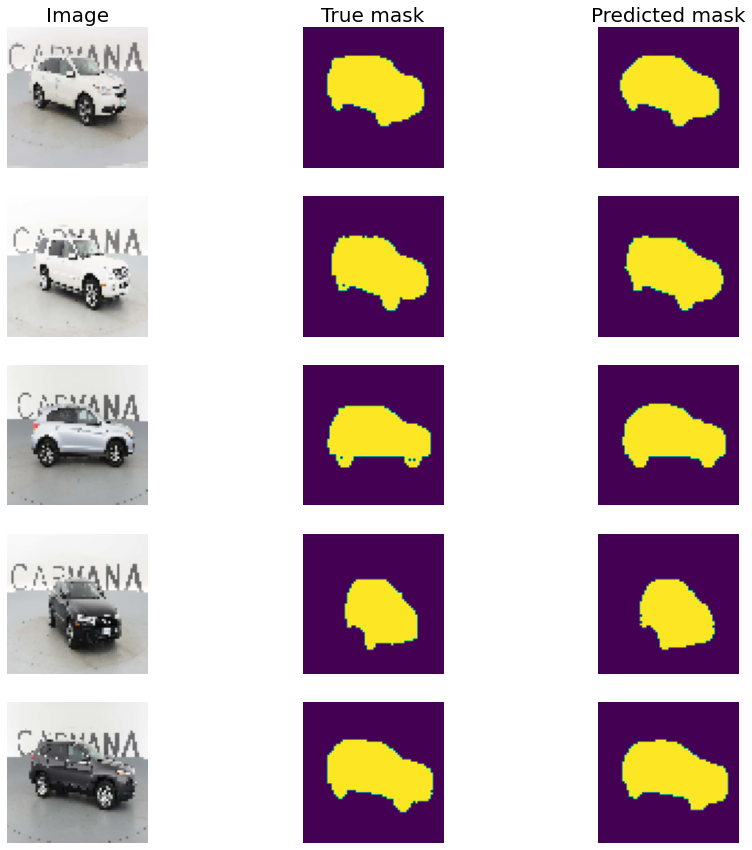

In [14]:
for inputs, labels in test_loader:
    inpt = tt.tensor(inputs.numpy()).cuda()
    lab = tt.tensor(labels.numpy()).cuda()
    outputs = net(inpt)
    break

fig, axs = plt.subplots(5, 3, figsize=(15, 15))
for n, ax in enumerate(axs.flat):
    if n % 3 == 0:
        ax.imshow(np.moveaxis(inpt.data[n // 3], -3, -1).get())
        ax.axis('off')
        if n == 0:
            ax.set_title('Image', fontsize=20)
    if n % 3 == 1:
        ax.imshow(lab.data[n // 3][0].get())
        ax.axis('off')
        if n == 1:
            ax.set_title('True mask', fontsize=20)
    if n % 3 == 2:
        ax.imshow(tt.sigmoid(outputs[n // 3][0]).data.get() > 0.5)
        ax.axis('off')
        if n == 2:
            ax.set_title('Predicted mask', fontsize=20)